<a href="https://colab.research.google.com/github/AyberkMunis/jailbreakturkishllm/blob/main/Test_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test Örnekleri


##1. Kullanılacak Metrikler

Örnek olarak **Llama 3.2 3B** modeli kullanılacaktır.

**Örnek Prompt**: Türkiye'nin başkenti neresidir?

**Cevap**: Ankara

**Amaç**: Bu promptun Ankara cevabına layer bazlı nasıl etkilediğini görmek.

**Kullanılacak Metrikler**:
1. $$
I_m^{(l)}(o) = \mathbf{e}_o^\top \cdot \text{LayerNorm}\left(\mathbf{m}_s^{(l)}\right)
$$
**Amaç**: Özne tokeninin her bir layerda hedef tokeni hakkında bilgi içerdiğini gözlememek.

**Açıklamalar:**

- \( l \): Transformer içindeki katman indeksi.
- **$l$**: Transformer içindeki katman indeksi.
- **$\mathbf{m}_s^{(l)}$**: Katman $l$'deki MLP çıkışı (son subject token için).
- **$\text{LayerNorm}(\cdot)$**: Katman normalizasyonu işlemi.
- **$\mathbf{e}_o$**: Doğru nesne tokeni $o$'nun unembedding (çıktı vektörü) temsili.
- **$I_m^{(l)}(o)$**: Modelin doğru nesne hakkında bilgi içerme düzeyi. Yüksekse model özne üzerinden nesne bilgisini içselleştirmiştir.

Detaylı açıklama: Mechanistic Understanding and Mitigation of Language Model
Non-Factual Hallucinations 2024, 4.1 Model inspection through logit lens (https://arxiv.org/pdf/2403.18167)





In [50]:
def compute_logit_lens_across_layers(
    model,
    tokenizer,
    prompt: str,
    subject_token: str,
    object_token_str: str,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
) -> List[float]:

    model.to(device)
    model.eval()

    # Tokenize giriş
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    # Konu tokeninin pozisyonunu bul
    subject_token_position=torch.where(input_ids==tokenizer.encode(subject_token)[-1])[-1].item()

    # Unembedding (lm_head weight) üzerinden object vektörü
    object_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(object_token_str)[0])
    e_o = model.lm_head.weight[object_token_id].to(device).to(torch.float32)

    # Hook'tan aktivasyonları toplayacak dict
    mlp_outputs = {}

    def get_hook_fn(layer_idx):
        def hook_fn(module, input, output):
            mlp_outputs[layer_idx] = output.detach()
        return hook_fn

    # Bütün katmanlara hook bağla
    hooks = []
    num_layers = len(model.model.layers)
    for layer_idx in range(num_layers):
        hook = model.model.layers[layer_idx].mlp.down_proj.register_forward_hook(get_hook_fn(layer_idx))
        hooks.append(hook)

    # Modeli çalıştır
    with torch.no_grad():
        _ = model(**inputs)

    # Hookları kaldır
    for hook in hooks:
        hook.remove()

    # Logit lens skorlarını hesapla
    scores = []
    for layer_idx in range(num_layers):
        if layer_idx not in mlp_outputs:
            scores.append(float('nan'))
            continue

        m_s_l = mlp_outputs[layer_idx][0, subject_token_position, :].to(torch.float32)
        hidden_dim = m_s_l.shape[-1]
        layernorm = nn.LayerNorm(hidden_dim).to(device)
        m_s_l_norm = layernorm(m_s_l)

        I_m_l_o = torch.dot(e_o, m_s_l_norm).item()
        scores.append(I_m_l_o)

    return scores

2.$$
I_a^{(l)}(o) = \mathbf{a}^{(l)\top} \cdot \left( \mathbf{e}_o - \bar{\mathbf{e}}_{O'} \right)
$$
**Amaç**: Attention çıktısının doğru token yönüne göre ne kadar ayırt edici olduğunu ölçer.

**Açıklamalar**:

$$
\begin{aligned}
\mathbf{a}^{(l)} & : \text{Attention çıktısı (son input token işlendikten sonra)} \\
\mathbf{e}_o & : \text{Doğru nesne tokeni } o \text{'nun unembedding vektörü} \\
O' & : \text{Yüksek bilgi taşıyan ama yanlış olan nesne token kümesi} \\
\bar{\mathbf{e}}_{O'} &= \frac{1}{|O'|} \sum_{o' \in O'} \mathbf{e}_{o'} \quad \text{(Ortalama yanlış nesne vektörü)} \\
I_a^{(l)}(o) & : \text{Attention modülünün doğru cevabı ayırt etme kapasitesi}
\end{aligned}
$$

Detaylı açıklama: Mechanistic Understanding and Mitigation of Language Model
Non-Factual Hallucinations 2024, 4.1 Model inspection through logit lens (https://arxiv.org/pdf/2403.18167)



In [73]:
def compute_Ia_all_layers(
    model,
    tokenizer,
    prompt: str,
    object_token_str: str,
    token_position: int = -1,
    top_k: int = 100,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):

    model.eval()
    model.to(device)

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    seq_len = input_ids.shape[1]

    object_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(object_token_str)[0])
    e_o = model.lm_head.weight[object_token_id].to(device).to(torch.float32)

    all_attn_outputs = []

    hooks = []
    for l in range(len(model.model.layers)):
        def get_hook(layer_idx):
            def hook_fn(module, input, output):
                all_attn_outputs.append(output.detach())
            return hook_fn
        hook = model.model.layers[l].self_attn.o_proj.register_forward_hook(get_hook(l))
        hooks.append(hook)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    for hook in hooks:
        hook.remove()

    E = model.lm_head.weight.to(device).to(torch.float32)

    I_a_scores = []

    for l in tqdm(range(len(model.model.layers)), desc="Computing I_a^{(l)}(o)"):
        a_l = all_attn_outputs[l][0, token_position, :].to(torch.float32)

        z_l = outputs.hidden_states[l + 1][0, token_position, :].to(torch.float32)

        logits = torch.matmul(E, z_l)
        top_indices = torch.topk(logits, top_k + 1).indices.tolist()

        top_wrong_ids = [i for i in top_indices if i != object_token_id][:top_k]
        e_o_primes = E[top_wrong_ids]

        e_o_bar = torch.mean(e_o_primes, dim=0)

        # I_a^{(l)}(o) = a_l^T (e_o - mean(e_o'))
        score = torch.dot(a_l, e_o - e_o_bar).item()
        I_a_scores.append(score)

    return I_a_scores


3.Layer Conductance

Bir ağın $L$ katmanındaki $j$ nöronunun iletkenliği şu şekilde tanımlanır:

$$
= \int_{\alpha=0}^{1}
\frac{\partial F(x' + \alpha(x - x'))}{\partial \gamma_y(\alpha)}
\cdot
\frac{\partial \gamma_y(\alpha)}{\partial \alpha}
\, d\alpha
$$

Açıklamalar:

- $ \int_{\alpha=0}^{1} $ : İntegral, $\alpha = 0$ ile $\alpha = 1$ aralığında alınır. Bu, giriş uzayında $x'$ (baseline) ile $x$ (gerçek giriş) arasında çizilen interpolasyon yoludur.

- $ x' + \alpha(x - x') $ : $x'$ ile $x$ arasında doğrusal bir yol tanımlar. $\alpha$ bu yol boyunca ilerlemeyi kontrol eder. $\alpha = 0$ için $x'$, $\alpha = 1$ için $x$ elde edilir.

- $ \frac{\partial F(x' + \alpha(x - x'))}{\partial \gamma_y(\alpha)} $ : Model çıktısı olan $F$ fonksiyonunun, ara katmandaki aktivasyon $\gamma_y(\alpha)$'ya göre kısmi türevidir. Yani: "Ara katmandaki küçük bir değişiklik, çıktıyı ne kadar etkiler?"

- $ \frac{\partial \gamma_y(\alpha)}{\partial \alpha} $ : Ara katman aktivasyonlarının, interpolasyon parametresi $\alpha$'ya göre türevidir. Bu da: "Yol boyunca gidildikçe iç aktivasyonlar nasıl değişiyor?" sorusunu yanıtlar.

- Bu ifade, **zincir kuralı** (chain rule) ile elde edilmiştir ve **Integrated Gradients** yöntemi gibi gradyan tabanlı açıklanabilirlik metotlarının temelini oluşturur.

Kaynak: https://captum.ai/api/layer.html,https://arxiv.org/abs/1805.12233,https://arxiv.org/abs/1807.09946

In [92]:
import torch
from captum.attr import LayerConductance

def FullLayerConductance(model, tokenizer, prompt, target_token, device):
    model.to(device)
    model.eval()  # Always set eval mode for attribution

    # Tokenize input and move to device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]

    # Get embeddings on device
    with torch.no_grad():
        input_embeds = model.model.embed_tokens(input_ids)

    # Enable gradients
    input_embeds.requires_grad_(True)

    # Get token ID(s) of target token
    target_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]

    attributions_per_layer = []
    layer_names = []

    def forward_func(input_embeds, target_id):
        outputs = model(inputs_embeds=input_embeds)
        logits = outputs.logits
        return logits[:, -1, target_id]

    # Loop over layers
    for x, layer in enumerate(model.model.layers):
        mlp = layer.mlp
        layer_names.append(f"Layer {x} MLP")

        lc = LayerConductance(forward_func, mlp)
        token_id_score = []
        attributions = lc.attribute(inputs=input_embeds, additional_forward_args=(target_token_id,))
        token_id_score.append(attributions.sum().item())

        avg_score = sum(token_id_score) / len(token_id_score)
        attributions_per_layer.append(avg_score)

    return attributions_per_layer, layer_names


## 2. Gerekli Kütüphanelerin kurulumu ve Veri Hazırlığı

In [2]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [132]:
from IPython.display import display, HTML
import numpy as np

def render_token_attribution(tokens, attributions, max_alpha=0.8):
    """
    Inline visualization: tokens colored based on attribution score.
    Red = negative, Blue = positive
    """
    attributions = np.array(attributions)
    norm = np.abs(attributions).max() + 1e-6  # avoid division by zero
    html = ""

    for token, score in zip(tokens, attributions):
        alpha = min(max_alpha, abs(score) / norm * max_alpha)
        if score > 0:
            color = f"rgba(0, 0, 255, {alpha})"  # Blue
        else:
            color = f"rgba(255, 0, 0, {alpha})"  # Red
        clean_token = token.replace("Ġ", " ")  # for GPT/BPE-style tokens
        html += f"<span style='background-color: {color}; padding:2px; margin:1px;'>{clean_token}</span>"

    display(HTML(html))



In [95]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from typing import List
from captum.attr import LayerConductance
from utils import *

from captum.attr import (
    FeatureAblation,
    ShapleyValues,
    LayerIntegratedGradients,
    LLMAttribution,
    LLMGradientAttribution,
    TextTokenInput,
    TextTemplateInput,
    ProductBaselines,
)

In [2]:
from huggingface_hub import notebook_login

notebook_login()


In [59]:
prompt="Türkiye'nin başkenti neresidir?"
objective=" Ankara"
subject=' başkenti'
prompt_en="The capital of Turkey is"
subject_en=" Turkey"

In [4]:
MODEL_NAME = "meta-llama/Llama-3.2-3B"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

## 3. Metriklerin Hesaplanması

In [63]:
#İlk olarak I_m_l_o metriğini hesaplayacağız
I_m_l_o_scores=compute_logit_lens_across_layers(model,tokenizer,prompt,subject,objective,DEVICE)
I_m_l_o_scores_en=compute_logit_lens_across_layers(model,tokenizer,prompt_en,subject_en,objective,DEVICE)


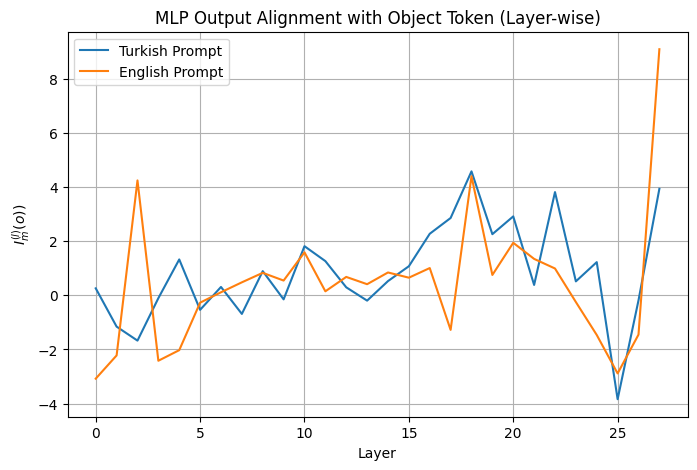

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(I_m_l_o_scores,label="Turkish Prompt")
plt.plot(I_m_l_o_scores_en,label="English Prompt")
plt.xlabel("Layer")
plt.ylabel(r"$I_m^{(l)}(o))$")
plt.title("MLP Output Alignment with Object Token (Layer-wise)")
plt.legend()
plt.grid(True)
plt.show()


In [74]:
I_a_scores=compute_Ia_all_layers(model,tokenizer,prompt,objective)
I_a_scores_en=compute_Ia_all_layers(model,tokenizer,prompt_en,objective)

Computing I_a^{(l)}(o): 100%|██████████| 28/28 [00:00<00:00, 634.73it/s]


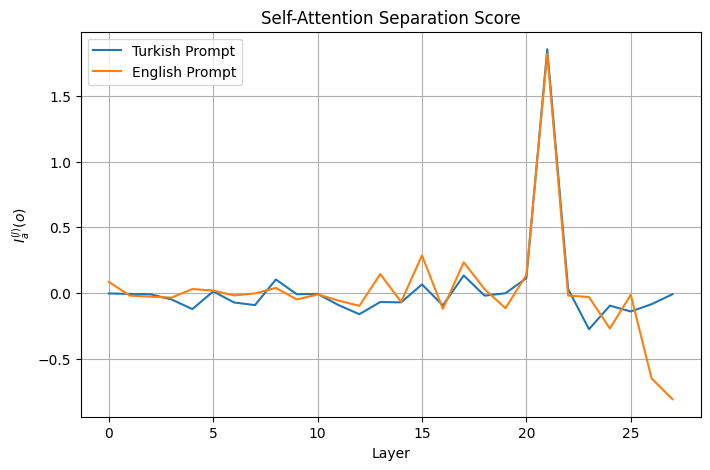

In [77]:
plt.figure(figsize=(8, 5))

plt.plot(I_a_scores,label="Turkish Prompt")
plt.plot(I_a_scores_en,label="English Prompt")
plt.xlabel("Layer")
plt.ylabel(r"$I_a^{(l)}(o)$")
plt.title("Self-Attention Separation Score")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
conductance=FullLayerConductance(model,tokenizer,prompt,objective,DEVICE)
conductance_en=FullLayerConductance(model,tokenizer,prompt_en,objective,DEVICE)

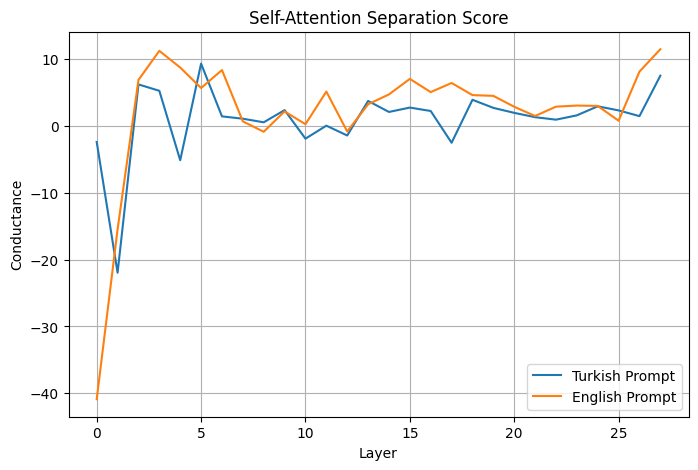

In [94]:
plt.figure(figsize=(8, 5))

plt.plot(conductance[0],label="Turkish Prompt")
plt.plot(conductance_en[0],label="English Prompt")
plt.xlabel("Layer")
plt.ylabel("Conductance")
plt.title("Self-Attention Separation Score")
plt.legend()
plt.grid(True)
plt.show()

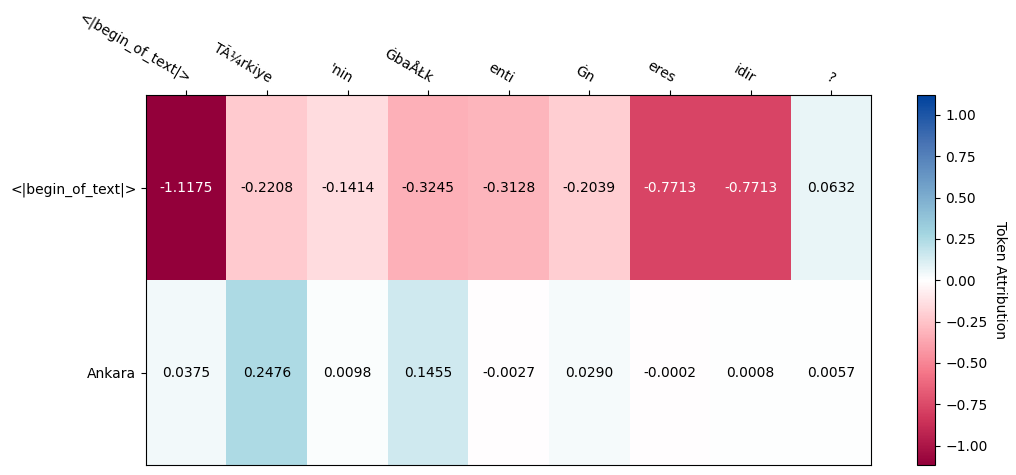

In [98]:
#Token Attribution
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)
skip_tokens = [1]  # skip the special token for the start of the text <s>
inp = TextTokenInput(
    prompt,
    tokenizer,
    skip_tokens=skip_tokens,
)

target = " Ankara"

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)
attr_res.plot_token_attr(show=True)


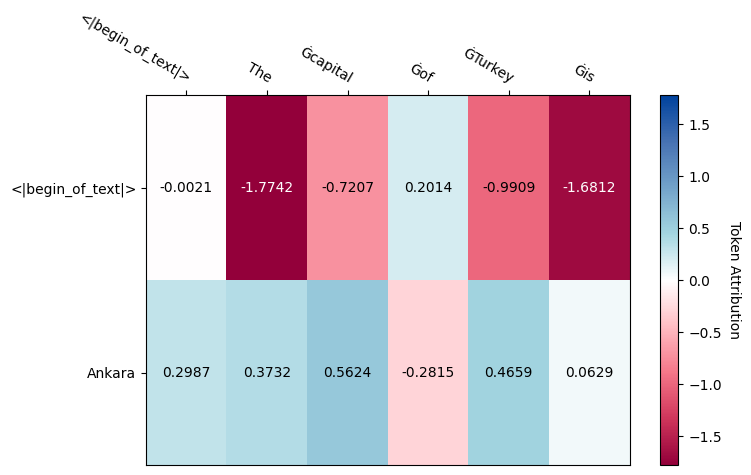

In [136]:

fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)
skip_tokens = [1]  # skip the special token for the start of the text <s>
inp = TextTokenInput(
    prompt_en,
    tokenizer,
    skip_tokens=skip_tokens,
)

target = " Ankara"

attr_res_en= llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)
attr_res_en.plot_token_attr(show=True)


## 4. Summary of Metrices

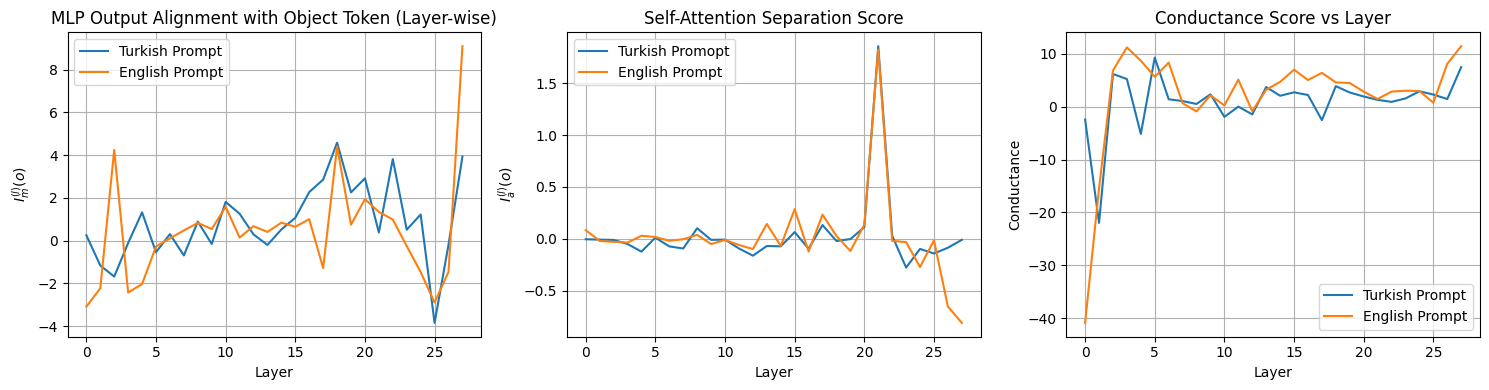

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 satır, 3 sütun

# Alt grafik 1: Doğrusal
axs[0].plot(I_m_l_o_scores,label='Turkish Prompt')
axs[0].plot(I_m_l_o_scores_en,label='English Prompt')


axs[0].set_title("MLP Output Alignment with Object Token (Layer-wise)")
axs[0].set_ylabel(r"$I_m^{(l)}(o)$")
axs[0].set_xlabel("Layer")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(I_a_scores,label='Turkish Promopt')
axs[1].plot(I_a_scores_en,label='English Prompt')
axs[1].set_title("Self-Attention Separation Score")
axs[1].set_ylabel(r"$I_a^{(l)}(o)$")
axs[1].set_xlabel("Layer")
axs[1].grid(True)
axs[1].legend()
axs[2].plot(conductance[0], label='Turkish Prompt')
axs[2].plot(conductance_en[0], label='English Prompt')
axs[2].set_ylabel("Conductance")
axs[2].set_xlabel("Layer")
axs[2].grid(True)
axs[2].legend()
axs[2].set_title("Conductance Score vs Layer")

plt.tight_layout()

plt.show()

In [130]:
input_ids=tokenizer.encode(prompt)
decoded_tokens=[tokenizer.decode(token) for token in input_ids]

In [137]:
input_ids_en=tokenizer.encode(prompt_en)
decoded_token_en=[tokenizer.decode(token) for token in input_ids_en]

In [131]:
decoded_tokens

['<|begin_of_text|>',
 'Türkiye',
 "'nin",
 ' başk',
 'enti',
 ' n',
 'eres',
 'idir',
 '?']

In [145]:
render_token_attribution(decoded_token_en,attr_res_en.token_attr[1].to('cpu'),0.7)
render_token_attribution(decoded_tokens,attr_res.token_attr[1].to('cpu'),2)